In [1]:
import math
import os
import random
import urllib
import sys
import zipfile

import tensorflow as tf
import numpy as np
import PIL

from scipy.ndimage.filters import gaussian_filter

# Download

In [2]:
model_url = 'http://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip'
base_name = model_url.split('/')[-1]

model_subfolder = 'inception5h' 
target_zip_path = os.path.join(model_subfolder, base_name)
unzip_to_folder = os.path.join(model_subfolder, 'extracted')
protobuff_path = os.path.join(unzip_to_folder, 'tensorflow_inception_graph.pb')

input_tensor_name = "input:0"

In [3]:
def hook(count, block_size, total_size):
    percentage = float(count * block_size) / total_size
    sys.stdout.write("\r Download progress: {:.1%}".format(percentage))
    sys.stdout.flush()

In [4]:
if not os.path.exists(model_subfolder):
    os.makedirs(model_subfolder)
    
if not os.path.exists(unzip_to_folder):
    if not os.path.exists(target_zip_path):
        file_path, _ = urllib.request.urlretrieve(model_url, target_zip_path, hook)
    else:
        file_path = target_zip_path

    zipfile.ZipFile(file_path).extractall(unzip_to_folder)

# Initialize

In [5]:
graph = tf.Graph()
sess = tf.Session(graph=graph)

In [6]:
with tf.gfile.FastGFile(protobuff_path, 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())

In [7]:
with graph.as_default():
    input_image_tensor = tf.placeholder(tf.float32, name='input')
    input_tensor = tf.expand_dims(input_image_tensor, 0)
    tf.import_graph_def(graph_def, {'input': input_tensor})

# Optimization

In [8]:
def load_image(filename):
    image = PIL.Image.open(filename)
    image_array = np.float32(image)
    return image_array

In [9]:
def image_from_array(img_arr):
    img_arr = np.clip(img_arr, 0, 255)
    img_arr  = np.uint8(img_arr)
    img_arr = PIL.Image.fromarray(img_arr)
    return img_arr

In [10]:
def plot_image(image, to_file=None, is_normalized=False):        
    if is_normalized:
        im = image_from_array(255 * image)
    else:
        im = image_from_array(image)
        
    if to_file:
        im.save(to_file)
    else:
        display(im)

In [11]:
def normalized(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

In [12]:
def resize_image(image, size=None, factor=None):
    img = image_from_array(image)
    final_size = img.size
    
    if size:
        final_size = size
    if factor:
        final_size = tuple(map(lambda x: int(x * factor), final_size))
        
    img = img.resize(final_size, PIL.Image.LANCZOS)
    img_arr = np.float32(img)
    return img_arr

In [13]:
def optimize_image(
    layer_tensor,
    image,
    gradient,
    num_iterations=10,
    step_size=3.0
):
    img = image.copy()
    
    print("Image before:")
    plot_image(img)
    
    print("Processing image: ", end="")
    for it in range(num_iterations):
        feed_dict = { input_image_tensor: img }
        g = sess.run(gradient, feed_dict=feed_dict)
        g /= (np.std(g) + 1e-8)
        
        sigma = (it * 4.0) / num_iterations + 0.5
        grad_smooth1 = gaussian_filter(g, sigma=sigma)
        grad_smooth2 = gaussian_filter(g, sigma=sigma*2)
        grad_smooth3 = gaussian_filter(g, sigma=sigma*0.5)
        g = (grad_smooth1 + grad_smooth2 + grad_smooth3)
                
        step_size_scaled = step_size / (np.std(g) + 1e-8)
        
        img += step_size_scaled * g
        print(". ", end="")
        
    print("Done!")
    
    return img

In [21]:
def recursive_optimize(
    layer_tensor,
    image,
    gradient,
    feature_channel=None,
    depth_level=4,
    rescale_factor=0.7,
    blend=0.2,
    num_iterations=10,
    step_size=3.0
):
    if depth_level > 0:
        sigma = 0.5
        img_blur = gaussian_filter(image, sigma=(sigma, sigma, 0.0))
        img_downscaled = resize_image(img_blur, factor=rescale_factor)
        img_result = recursive_optimize(
            layer_tensor,
            img_downscaled,
            gradient,
            feature_channel=feature_channel,
            depth_level=depth_level-1,
            rescale_factor=rescale_factor,
            blend=blend,
            num_iterations=num_iterations,
            step_size=step_size
        )
        img_upscaled = resize_image(img_result, size=(image.shape[1],image.shape[0]))
        image = blend * image + (1 - blend) * img_upscaled

    print("Depth level:", depth_level)
    img_result = optimize_image(layer_tensor, image, gradient, num_iterations, step_size)
    return img_result

In [15]:
def deepdream(
    layer_tensor,
    image,
    squared=True,
    feature_channel=None,
    depth_level=4,
    rescale_factor=0.7,
    blend=0.2,
    num_iterations=10,
    step_size=3.0
):

    with graph.as_default():
        if isinstance(layer_tensor, str):
                layer_tensor = graph.get_tensor_by_name('import/%s:0' % layer_tensor)
                
        if squared:
            layer_tensor = tf.square(layer_tensor)
            
        if feature_channel is not None:
            layer_tensor = layer_tensor[..., feature_channel]
            
        objective = tf.reduce_mean(layer_tensor)
        gradient = tf.gradients(objective, input_image_tensor)[0]
            
    result = recursive_optimize(
        layer_tensor,
        image,
        gradient,
        feature_channel=feature_channel,
        depth_level=depth_level,
        rescale_factor=rescale_factor,
        blend=blend,
        num_iterations=num_iterations,
        step_size=step_size
    )
    return result

# Dreaming

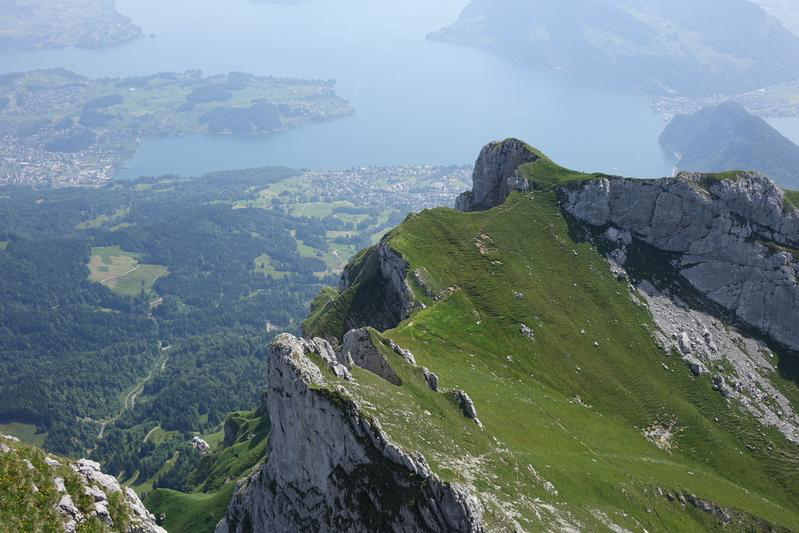

Depth level: 0
Image before:


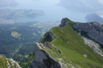

Processing image: . . . . . . . . . . . . . . . . . . . . Done!
Depth level: 1
Image before:


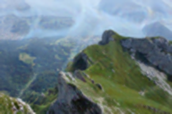

Processing image: . . . . . . . . . . . . . . . . . . . . Done!
Depth level: 2
Image before:


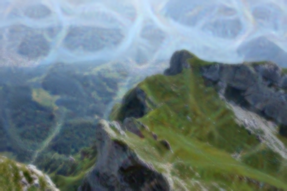

Processing image: . . . . . . . . . . . . . . . . . . . . Done!
Depth level: 3
Image before:


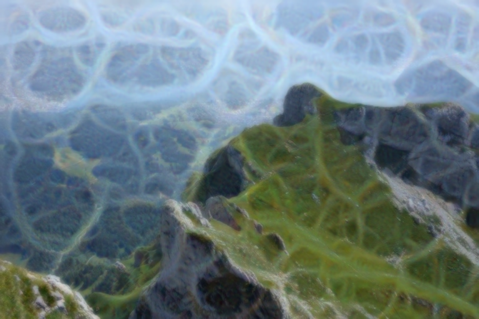

Processing image: . . . . . . . . . . . . . . . . . . . . Done!
Depth level: 4
Image before:


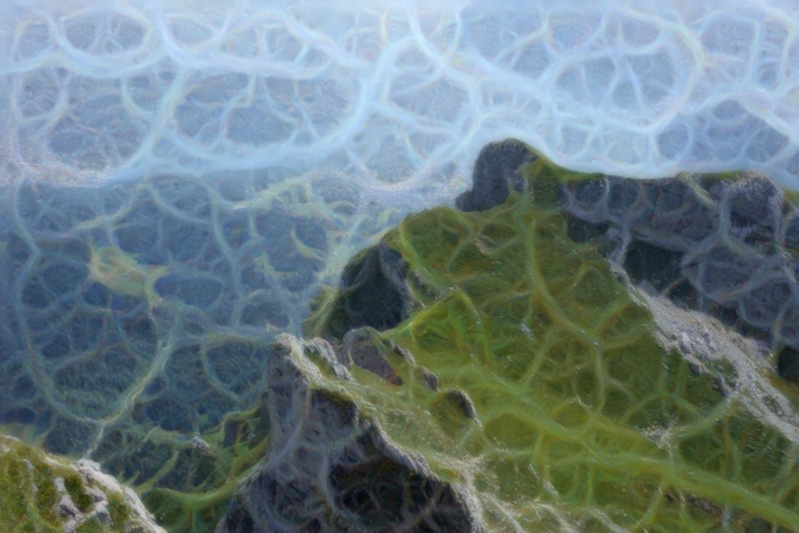

Processing image: . . . . . . . . . . . . . . . . . . . . Done!


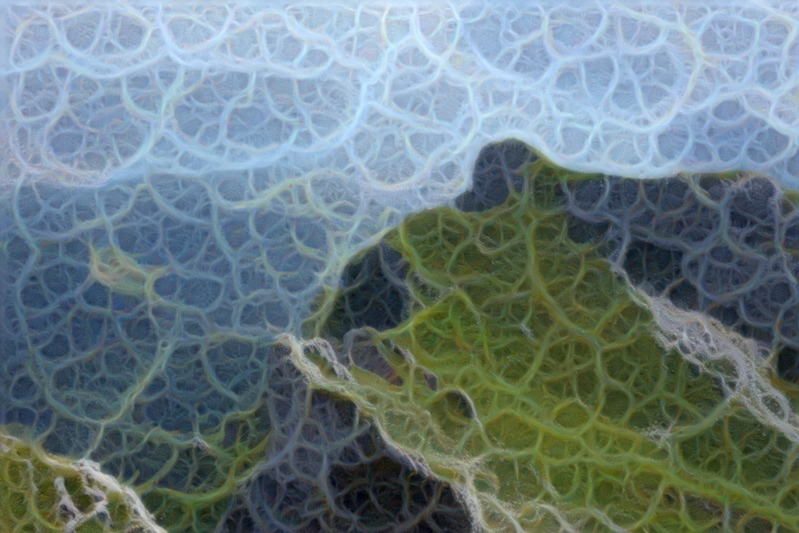

In [16]:
img0 = load_image('images/pilatus800.jpg')
plot_image(img0)

img_result = deepdream(
    'mixed4a',
    img0,
    feature_channel=67,
    squared=False,
    depth_level=4,
    rescale_factor=0.6,
    blend=0.2,
    num_iterations=20,
    step_size=1.0
)
plot_image(img_result)

# Misc

* Veins / Neurons - mixed4a_1x1_pre_relu (67)

# Helpers

In [17]:
layers = [op.name for op in graph.get_operations() if op.type=='Conv2D']
feature_nums = [int(graph.get_tensor_by_name(name+':0').get_shape()[-1]) for name in layers]
layers_with_feature_numbers = sorted(list(zip(layers, feature_nums)), key=lambda x: x[0])
from pprint import pprint
pprint(layers_with_feature_numbers)


[('import/conv2d0_pre_relu/conv', 64),
 ('import/conv2d1_pre_relu/conv', 64),
 ('import/conv2d2_pre_relu/conv', 192),
 ('import/head0_bottleneck_pre_relu/conv', 128),
 ('import/head1_bottleneck_pre_relu/conv', 128),
 ('import/mixed3a_1x1_pre_relu/conv', 64),
 ('import/mixed3a_3x3_bottleneck_pre_relu/conv', 96),
 ('import/mixed3a_3x3_pre_relu/conv', 128),
 ('import/mixed3a_5x5_bottleneck_pre_relu/conv', 16),
 ('import/mixed3a_5x5_pre_relu/conv', 32),
 ('import/mixed3a_pool_reduce_pre_relu/conv', 32),
 ('import/mixed3b_1x1_pre_relu/conv', 128),
 ('import/mixed3b_3x3_bottleneck_pre_relu/conv', 128),
 ('import/mixed3b_3x3_pre_relu/conv', 192),
 ('import/mixed3b_5x5_bottleneck_pre_relu/conv', 32),
 ('import/mixed3b_5x5_pre_relu/conv', 96),
 ('import/mixed3b_pool_reduce_pre_relu/conv', 64),
 ('import/mixed4a_1x1_pre_relu/conv', 192),
 ('import/mixed4a_3x3_bottleneck_pre_relu/conv', 96),
 ('import/mixed4a_3x3_pre_relu/conv', 204),
 ('import/mixed4a_5x5_bottleneck_pre_relu/conv', 16),
 ('impor

In [18]:
import re
regex = re.compile('/([a-z]+[a-z0-9]+)_')
high_level_layers = set()
for l in layers:
    res = regex.search(l)
    if res is not None: high_level_layers.add(res.group(1))
print(sorted(list(high_level_layers)))

['conv2d0', 'conv2d1', 'conv2d2', 'head0', 'head1', 'mixed3a', 'mixed3b', 'mixed4a', 'mixed4b', 'mixed4c', 'mixed4d', 'mixed4e', 'mixed5a', 'mixed5b']


In [19]:
def visstd(a, s=0.1):
    return (a-a.mean())/max(a.std(), 1e-4)*s + 0.5

In [20]:
sess.close()